In [30]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown as md
from ipywidgets import interact
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC

# SVM

Support Vector Machines (SVM) são modelos de aprendizado *supervisionado* utilizados em tarefas de classificação e de regressão. Visam maximizar a margem entre diferentes classes, encontrando uma reta $\left(\mathbb{R}^2\right)$, plano $\left(\mathbb{R}^3\right)$ ou hiperplano $\left(\mathbb{R}^n, n > 3\right)$ que melhor separam os dados.

São capazes de realizar essas tarefas sobre dados com características lineares, e, utilizando o _kernel trick_ apresentado anteriormente, pode ser extendida para dados não-lineares, a partir de comparações de similaridade entre pares. 

Para entender melhor o propósito desses modelos, vamos observar alguns casos em duas dimensões.

Imagine um conjunto de dados com duas classes, por exemplo, uma classificação binária de pessoas doentes ou saudáveis, com base em dois atributos quaisquer.

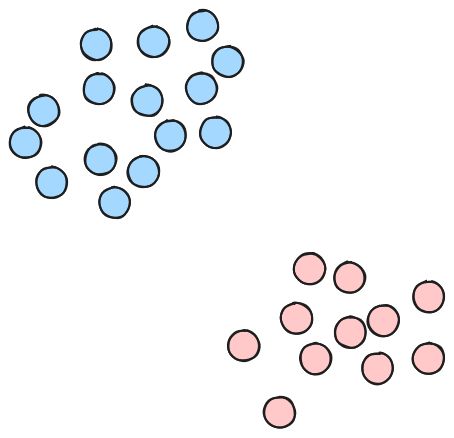

Queremos determinar a fronteira que melhor separa essas duas classes. Como estamos em duas dimensões, já sabemos que essa fronteira será uma reta. Vamos analisar alguns casos possíveis:

1. Falha: a reta traçada não separa essas duas classes corretamente. Há pessoas do grupo de pessoas saudáveis que foram classificadas como doentes.

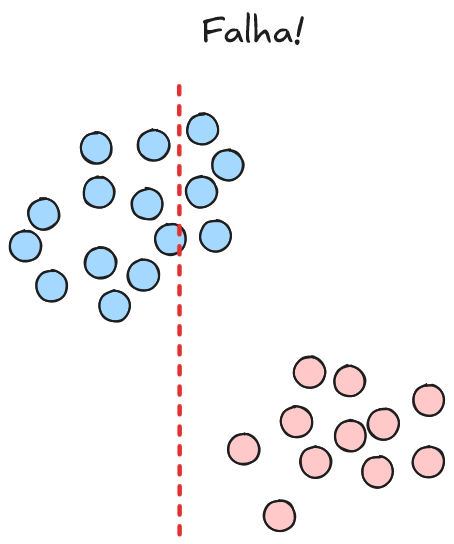

2. Correto não-ótimo: a reta traça uma fronteira que separa corretamente as duas classes, mas a margem entre as classes é pequena. Uma pequena alteração no comportamento dos dados pode levar a uma classificação incorreta.

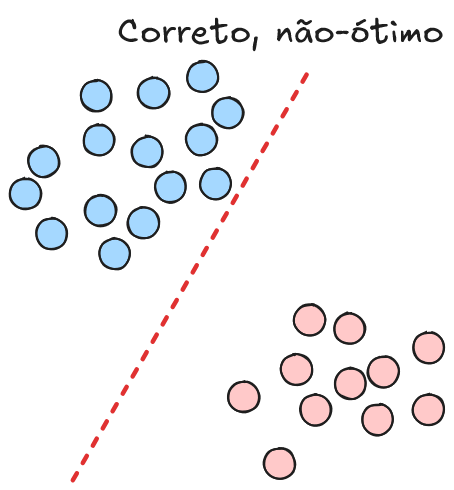

3. Ótimo: caso único onde a soma das diferenças entre a fronteira e os pontos mais próximos de cada classe é maximizada. Essa é a solução que um SVC (_Support Vector Classifier_, um caso específico de SVM) busca encontrar.

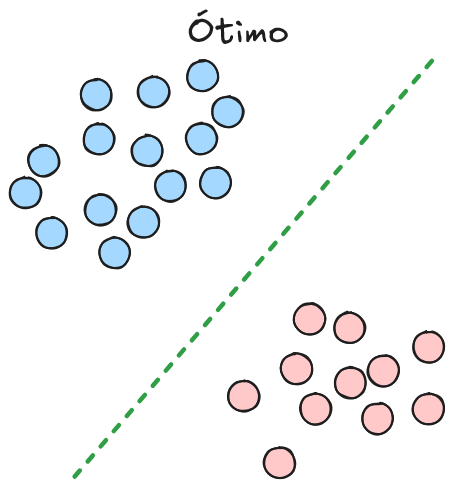

## Exemplo prático

Vamos tentar replicar o caso ilustrado acima utilizando a biblioteca `sklearn` do Python. Primeiro, vamos gerar os dados sintéticos:

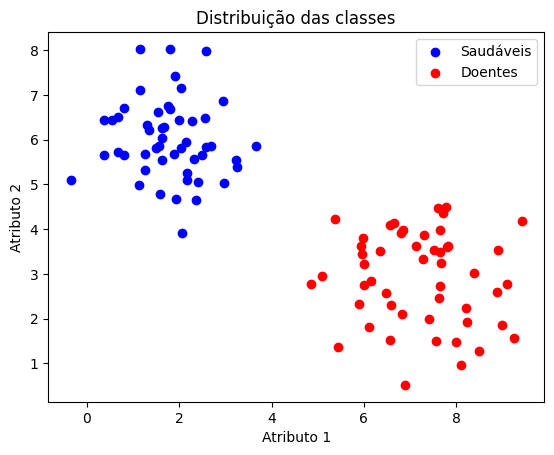

In [31]:
# Classe de pessoas saudáveis no canto superior esquerdo
saudaveis = np.random.multivariate_normal(mean=[2, 6], cov=[[1, 0], [0, 1]], size=50)
# Classe de pessoas doentes no canto inferior direito
doentes = np.random.multivariate_normal(mean=[7, 3], cov=[[1, 0], [0, 1]], size=50)

plt.scatter(saudaveis[:, 0], saudaveis[:, 1], color='blue', label='Saudáveis')
plt.scatter(doentes[:, 0], doentes[:, 1], color='red', label='Doentes')
plt.xlabel('Atributo 1')
plt.ylabel('Atributo 2')
plt.legend()
plt.title('Distribuição das classes')
plt.show()

Com os dados parecidos, podemos agora utilizar um `SVC` (Support Vector Classifier) para encontrar a melhor fronteira de decisão entre as duas classes.

In [32]:
svc = SVC(kernel='linear') # Por padrão, o SVC utiliza um kernel gaussiano (RBF), nesse caso, isso não é necessário
X = np.vstack((saudaveis, doentes))
y = np.array([0]*50 + [1]*50)  # 0 para saudáveis, 1 para doentes
svc.fit(X, y)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


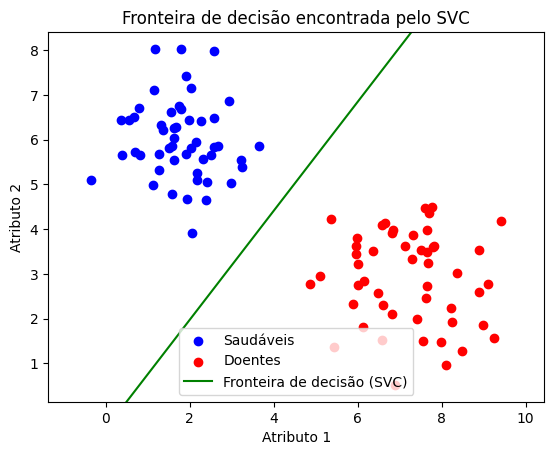

In [33]:
line_func = lambda x: (-svc.coef_[0][0] * x - svc.intercept_[0]) / svc.coef_[0][1]

plt.scatter(saudaveis[:, 0], saudaveis[:, 1], color='blue', label='Saudáveis')
plt.scatter(doentes[:, 0], doentes[:, 1], color='red', label='Doentes')
# Constrain line to the plot limits
xlim = plt.xlim()
ylim = plt.ylim()
x_vals = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x_vals, line_func(x_vals), color='green', label='Fronteira de decisão (SVC)')
plt.ylim(ylim)
plt.xlabel('Atributo 1')
plt.ylabel('Atributo 2')
plt.legend()
plt.title('Fronteira de decisão encontrada pelo SVC')
plt.show()

## Exemplo de aplicação de kernel não-linear

Vamos observar o mesmo caso apresentado nos slides anteriormente: círculos concêntricos representando duas classes diferentes.

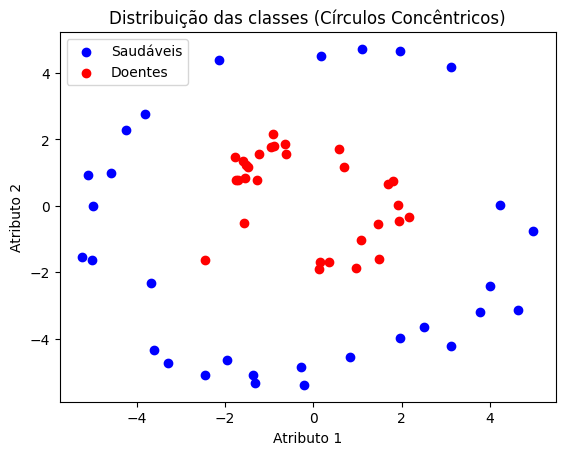

In [34]:
def generate_circle_points(radius:float, n:int) -> np.ndarray:
    arr = np.zeros((n, 2))
    for i in range(n):
        angle = np.random.uniform(0, 2 * np.pi)
        r = radius + np.random.normal(0, 1/3)  # Pequena variação no raio
        arr[i] = [r * np.cos(angle), r * np.sin(angle)]
    return arr

saudaveis_cc = generate_circle_points(5, 30)
doentes_cc = generate_circle_points(2, 30)
plt.scatter(saudaveis_cc[:, 0], saudaveis_cc[:, 1], color='blue', label='Saudáveis')
plt.scatter(doentes_cc[:, 0], doentes_cc[:, 1], color='red', label='Doentes')
plt.xlabel('Atributo 1')
plt.ylabel('Atributo 2')
plt.legend()
plt.title('Distribuição das classes (Círculos Concêntricos)')
plt.show()

Nesse caso, é impossível traçar uma reta que separe as duas classes. Vamos aplicar um _feature map_ simples para demonstrar como contornar esse problema.

$$ f(x, y) = (x, y, x^2 + y^2) $$

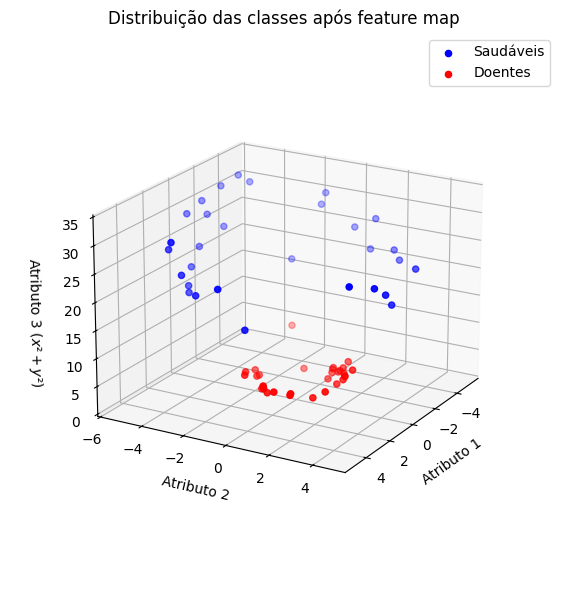

In [35]:
feature_map = lambda x, y: np.array([x, y, x**2 + y**2])
X_cc = np.array([feature_map(x, y) for x, y in np.vstack((saudaveis_cc, doentes_cc))])
# 3d scatter
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': '3d'})
ax.view_init(elev=20, azim=30) # type: ignore
ax.scatter(X_cc[:30, 0], X_cc[:30, 1], X_cc[:30, 2], color='blue', label='Saudáveis')
ax.scatter(X_cc[30:, 0], X_cc[30:, 1], X_cc[30:, 2], color='red', label='Doentes')
ax.legend()
ax.set_xlabel('Atributo 1', labelpad=10)
ax.set_ylabel('Atributo 2', labelpad=10)
ax.set_zlabel('Atributo 3 $\\left(x² + y²\\right)$', labelpad=10) # type: ignore
ax.set_title('Distribuição das classes após feature map')
ax.set_box_aspect(None, zoom=0.8)  # type: ignore
fig.tight_layout()
plt.show()

Agora, obtemos um caso parecido com o exemplo anterior do slide. Podemos então aplicar o SVC para encontrar a fronteira de decisão ótima nesse espaço transformado.

In [36]:
svc = SVC(kernel='linear')
y_cc = np.array([0] * 30 + [1] * 30)
svc.fit(X_cc, y_cc)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


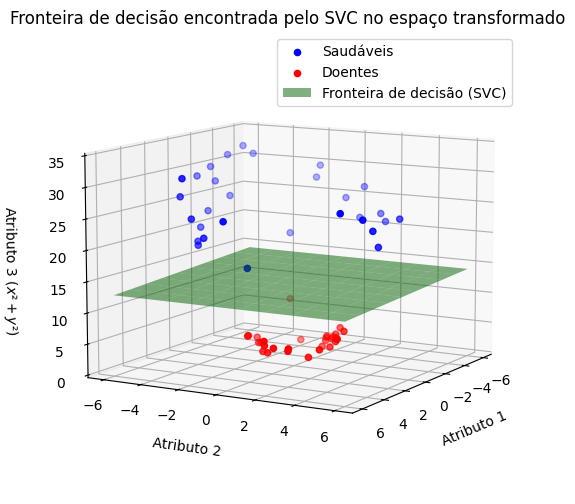

In [37]:
# Coeficientes do plano: w0*x + w1*y + w2*z + b = 0
w0, w1, w2 = svc.coef_[0]
b = svc.intercept_[0]

# Resolvendo para z:
plane_func = lambda x, y: -(w0 * x + w1 * y + b) / w2

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': '3d'})
ax.view_init(elev=10, azim=30) # type: ignore
ax.scatter(X_cc[:30, 0], X_cc[:30, 1], X_cc[:30, 2], color='blue', label='Saudáveis')
ax.scatter(X_cc[30:, 0], X_cc[30:, 1], X_cc[30:, 2], color='red', label='Doentes')
# Create grid to plot the plane
x_range = np.linspace(-6, 6, 10)
y_range = np.linspace(-6, 6, 10)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = plane_func(X_grid, Y_grid)
ax.plot_surface(X_grid, Y_grid, Z_grid, alpha=0.5, color='green', label='Fronteira de decisão (SVC)')  # type: ignore
ax.legend()
ax.set_xlabel('Atributo 1', labelpad=10)
ax.set_ylabel('Atributo 2', labelpad=10)
ax.set_zlabel('Atributo 3 $\\left(x² + y²\\right)$', labelpad=10) # type: ignore
ax.set_title('Fronteira de decisão encontrada pelo SVC no espaço transformado')
plt.show()

## Exemplo: uso de _Kernel Trick_

Como comentado em slides anteriormente, é possível evitar a aplicação de um _feature map_ diretamente a partir do uso de funções _kernel_, essa técnica recebe o nome de _kernel trick_. Vamos observar como isso pode ser feito utilizando o mesmo exemplo dos círculos concêntricos.

In [38]:
svc = SVC(kernel='rbf') # Uso de kernel gaussiano (RBF)
X_cc_exclude_feature_map = X_cc[:, :2]
y_cc = np.array([0] * 30 + [1] * 30)
svc.fit(X_cc_exclude_feature_map, y_cc)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Nesse caso, não é possível visualizar uma única reta ou plano que separa os dados. Nesse caso, precisamos plotar uma *curva de nível*.

In [39]:
xx, yy = np.meshgrid(
    np.linspace(X_cc_exclude_feature_map[:,0].min()-1, X_cc_exclude_feature_map[:,0].max()+1, 500),
    np.linspace(X_cc_exclude_feature_map[:,1].min()-1, X_cc_exclude_feature_map[:,1].max()+1, 500)
)
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape) # Função de decisão do SVC

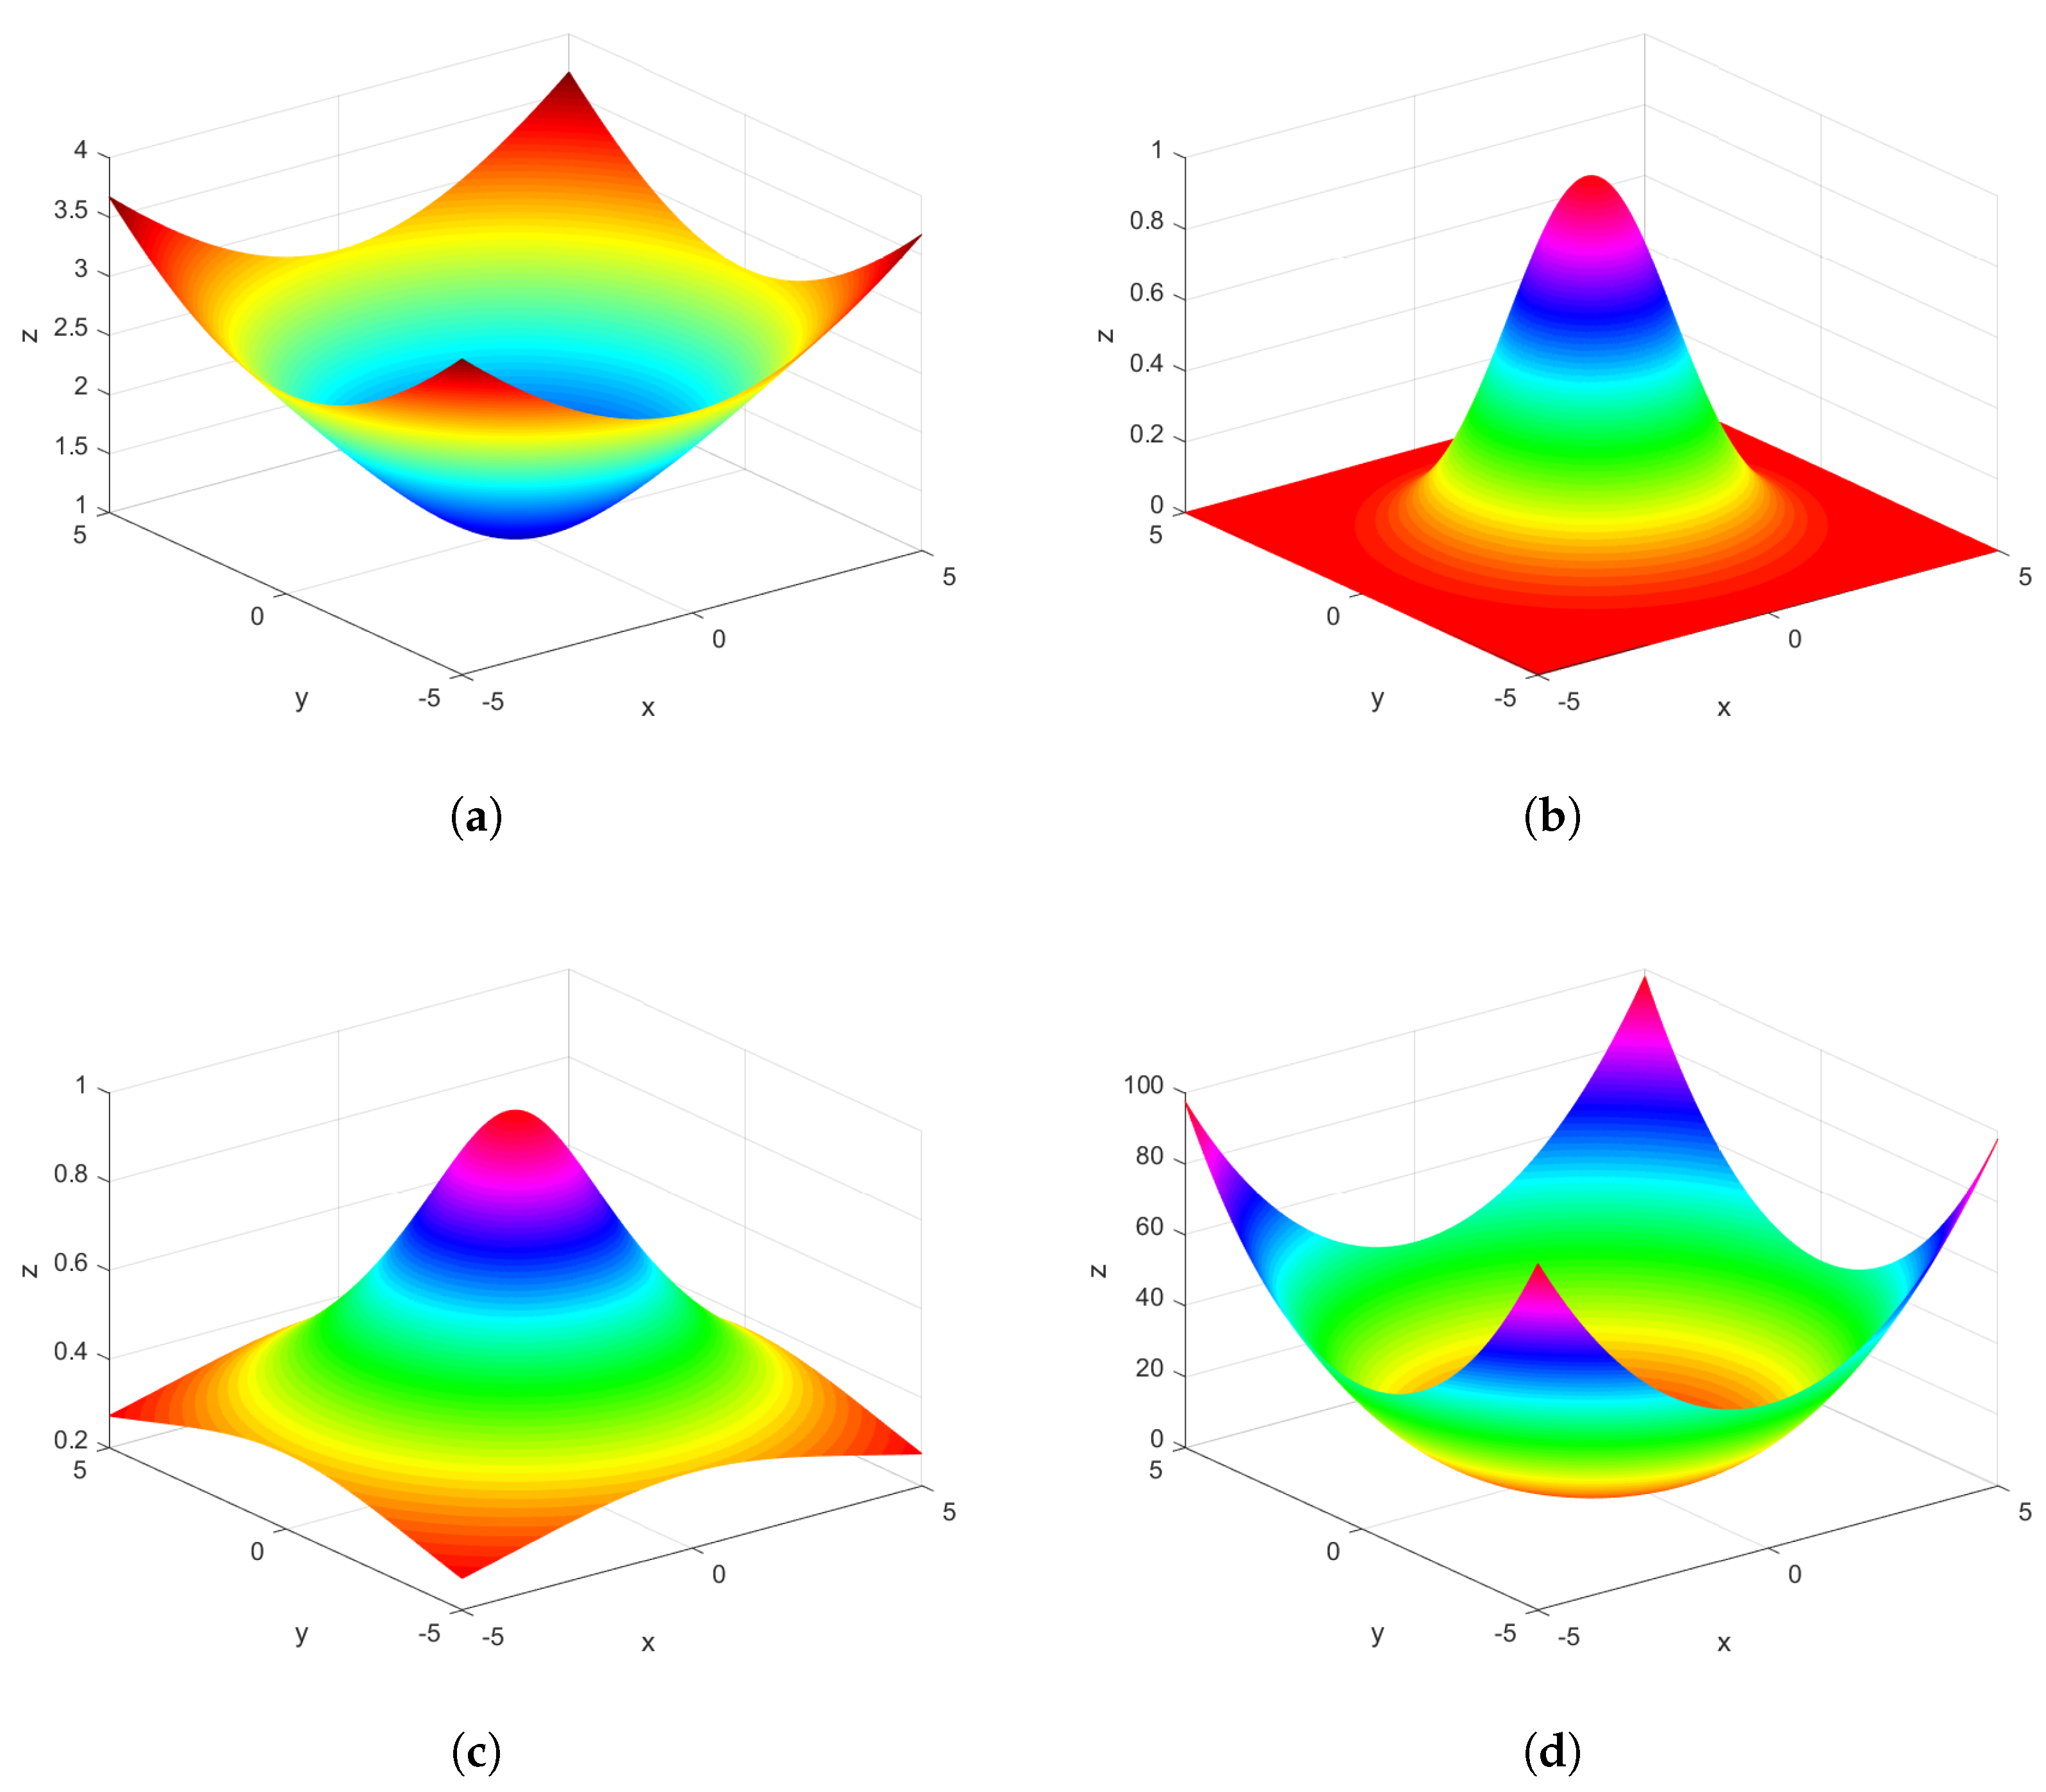

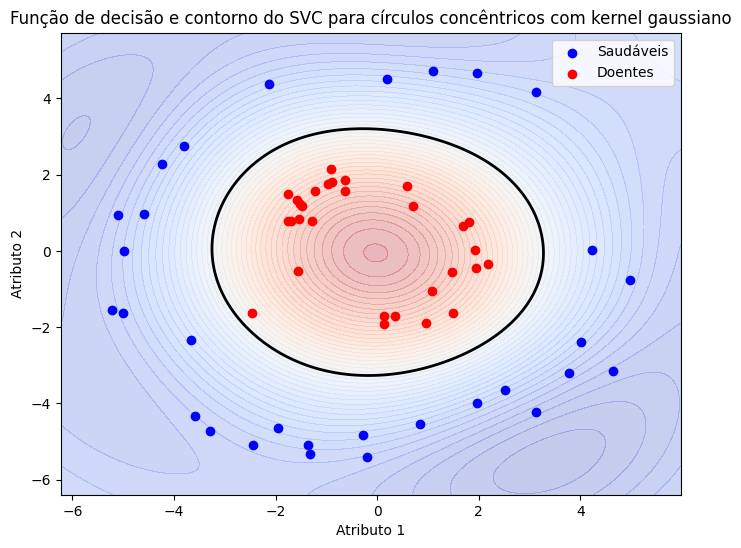

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.3)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)  # decision boundary
ax.scatter(saudaveis_cc[:, 0], saudaveis_cc[:, 1], color='blue', label='Saudáveis')
ax.scatter(doentes_cc[:, 0], doentes_cc[:, 1], color='red', label='Doentes')
ax.legend()
ax.set_title("Função de decisão e contorno do SVC para círculos concêntricos com kernel gaussiano")
ax.set_xlabel('Atributo 1')
ax.set_ylabel('Atributo 2')
plt.show()

# Recapitulando PCA, introduzindo Kernel PCA

O PCA (Análise de Componentes Principais) visa reduzir a dimensionalidade de um conjunto de dados a partir de correlações entre variáveis linearmente independentes, chamadas componentes principais. Em suma, o objetivo do PCA é:
1. Identificar as direções (componentes principais) ao longo das quais a variação dos dados é máxima;
2. Projetar os dados originais nessas direções para obter uma representação de menor dimensão, preservando o máximo possível da variação original.

Da mesma forma que métodos SVM, o PCA pode ser extendido para dados não-lineares utilizando o _kernel trick_, resultando no Kernel PCA (KPCA), esse permitindo projetar os dados de entrada em um espaço de maior dimensão onde relações lineares podem ser exploradas.

In [41]:
X_high_dim = X_cc_exclude_feature_map @ np.random.randn(2, 10)  # Projeção aleatória para 10 dimensões

In [42]:
# ==================== PCA ====================
# Manualmente, sem scikit-learn
X_high_dim_mean = np.mean(X_high_dim, axis=0)
X_centered = X_high_dim - X_high_dim_mean
X_standardized = X_centered
cov_matrix = np.cov(X_standardized, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Ordenar autovalores e autovetores
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
# Projetar nos dois primeiros componentes principais
X_pca = X_standardized @ eigenvectors[:, :2]
# Com scikit-learn
pca = PCA(n_components=2)
X_pca_sklearn = pca.fit_transform(X_high_dim)
# ==============================================

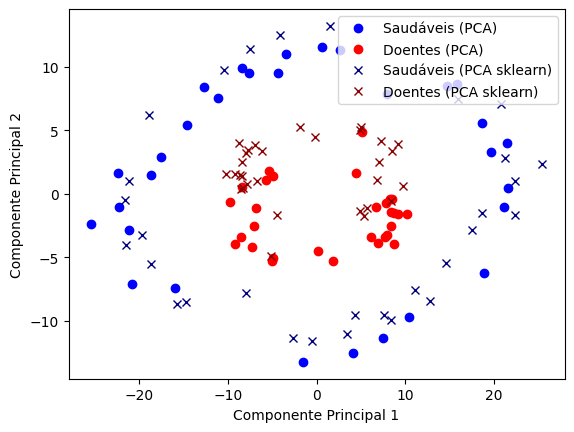

In [43]:
plt.plot(X_pca[y_cc==0, 0], X_pca[y_cc==0, 1], 'o', label='Saudáveis (PCA)', color='blue')
plt.plot(X_pca[y_cc==1, 0], X_pca[y_cc==1, 1], 'o', label='Doentes (PCA)', color='red')
plt.plot(X_pca_sklearn[y_cc==0, 0], X_pca_sklearn[y_cc==0, 1], 'x', label='Saudáveis (PCA sklearn)', color='navy')
plt.plot(X_pca_sklearn[y_cc==1, 0], X_pca_sklearn[y_cc==1, 1], 'x', label='Doentes (PCA sklearn)', color='darkred')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()

In [44]:
def update_kpca(gamma):
    # ==================== KPCA ====================
    # Kernel utilizado: RBF (Gaussiano)
    kernel_matrix = rbf_kernel(X_high_dim, X_high_dim, gamma=gamma)
    m = kernel_matrix.shape[0]
    H = np.eye(m) - np.full((m, m), 1 / m)
    K_centered = H @ kernel_matrix @ H
    eigenvalues_kpca, eigenvectors_kpca = np.linalg.eigh(K_centered)
    sorted_indices_kpca = np.argsort(eigenvalues_kpca)[::-1]
    eigenvalues_kpca = eigenvalues_kpca[sorted_indices_kpca]
    eigenvectors_kpca = eigenvectors_kpca[:, sorted_indices_kpca]
    # Projetar nos dois primeiros componentes principais do KPCA
    X_kpca = K_centered @ eigenvectors_kpca[:, :2]
    # Com scikit-learn
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca_sklearn = kpca.fit_transform(X_high_dim)
    # ==============================================
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(X_kpca[y_cc==0, 0], X_kpca[y_cc==0, 1], 'o', label='Saudáveis (PCA)', color='blue')
    axs[0].plot(X_kpca[y_cc==1, 0], X_kpca[y_cc==1, 1], 'o', label='Doentes (PCA)', color='red')
    axs[1].plot(X_kpca_sklearn[y_cc==0, 0], X_kpca_sklearn[y_cc==0, 1], 'x', label='Saudáveis (PCA sklearn)', color='navy')
    axs[1].plot(X_kpca_sklearn[y_cc==1, 0], X_kpca_sklearn[y_cc==1, 1], 'x', label='Doentes (PCA sklearn)', color='darkred')
    axs[0].set_xlabel('Componente Principal 1')
    axs[0].set_ylabel('Componente Principal 2')
    axs[1].set_xlabel('Componente Principal 1')
    axs[1].set_ylabel('Componente Principal 2')
    axs[0].legend()
    axs[1].legend()
    plt.show()

interact(update_kpca, gamma=(0.01, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.5, description='gamma', max=1.0, min=0.01, step=0.01), Output()), _d…

<function __main__.update_kpca(gamma)>